# Simple Fully Connected network for MNIST

This tutorial is heavily base on Neural Networks and Deep Learning ([http://neuralnetworksanddeeplearning.com/chap2.html](http://neuralnetworksanddeeplearning.com/chap2.html)) by Michael Nielsen.

The **matplotlib** and **scipy** package will be used to output graphs.

For simplicity (and laziness) we will use **tensorflow** package to automatically download and use MNIST data (this might be fix in future update)

To run this notebook you will need to install (with pip or equivalent) :
```numpy scipy matplotlib tensorflow```

In [1]:
%matplotlib inline

import numpy as np

import scipy.stats as stats
import matplotlib

## Network creation

The MNIST data are 28x28 grayscaled images, each pixel holds a value between 0 and 1 (32 bit float numbers)

We will build a network with **2 fully connected layers** of 16 and 10 neurons (the last layer has to be the same dimension as the output).

The following neuron_outputs initialization of the layers is unecessary as the numpy arrays will not be filled be replaced during the operations. This is mainly to help visualizing layout of the network.

In [2]:
input_dimension = 784  # 28 x 28 grayscale images
output_dimmension = 10

layers = ["input", "fc1", "fc2"]  # list of layers name, please make sure of the unicity of the names
neuron_outputs = {}
neuron_outputs["input"] = np.empty(input_dimension)
neuron_outputs["fc1"] = np.empty(16)
neuron_outputs["fc2"] = np.empty(output_dimmension)

### Weights initialization

Now that we know our layer sizes we can create the corresponding wiehgts and biases.

When saving a network weigths and biases are the values stored (sometime the layout description is also embedded).

At first we will naively initialize weights and biases at 0 and see the result before thinking of better initilization.

More on weight initialization : [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/neural-networks-2/#init)

In [3]:
weights = {}
biases = {}

def reset_network_zero():
    for layer_index in range(1, len(layers)):
        # initialize as 0
        weights[layers[layer_index]] = np.zeros(
            (neuron_outputs[layers[layer_index - 1]].shape[0],
             neuron_outputs[layers[layer_index]].shape[0]))
        biases[layers[layer_index]] = np.zeros(neuron_outputs[layers[layer_index]].shape[0])

reset_network_zero()
plot_weigths = weights["fc1"].flatten()
matplotlib.pyplot.hist(plot_weigths, 100, normed=1)
matplotlib.pyplot.xlabel('Probablity')
matplotlib.pyplot.ylabel('Value')
matplotlib.pyplot.title("Zeroed FC1 weight distribution")
print()

To better understand the weight shapes we will print them out. Notice that during initialization we used the layers shape dynamically so you can change the numbers as you wish.

In [4]:
for layer in layers[1:]:  # not listing the first layer (input) as it has no weights/biases associated to it
    print("Layer : " + layer)
    print("   Weigths shapes : %s\n   Weigths totals: %s\n   Biases shapes: %s" % (
        weights[layer].shape,
        weights[layer].shape[0] * weights[layer].shape[1],
        biases[layer].shape))

Layer : fc1
   Weigths shapes : (784, 16)
   Weigths totals: 12544
   Biases shapes: (16,)
Layer : fc2
   Weigths shapes : (16, 10)
   Weigths totals: 160
   Biases shapes: (10,)


### Activation function

Deep neural networks need a non linear function applied for each neuron : the activation function. Without it the network could be just simplify to a single layer network, this is a working Machine Learning process but deep neural network can handl more complex operation.

Here we have 2 layers so we definitevely want to use an activation function. We will use the standard Sigmoid.

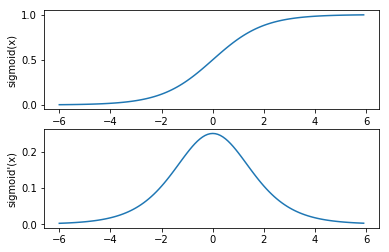

In [5]:
def sigmoid(p_input):
    return 1.0 / (1.0 + np.exp(-p_input))

def sigmoid_prime(p_input):
    return sigmoid(p_input) * (1 - sigmoid(p_input))

plot_x = np.arange(-6, 6, 0.1)
matplotlib.pyplot.figure(1)
matplotlib.pyplot.subplot(211)
matplotlib.pyplot.ylabel("sigmoid(x)")
matplotlib.pyplot.plot(plot_x, sigmoid(plot_x))
matplotlib.pyplot.subplot(212)
matplotlib.pyplot.ylabel("sigmoid'(x)")
matplotlib.pyplot.plot(plot_x, sigmoid_prime(plot_x))
print()

We will use a wrapper for the activation function as we will change it after.

In [6]:
def activation(p_input):
    return sigmoid(p_input)

def activation_prime(p_input):
    return sigmoid_prime(p_input)

### Prediction

With the **weigths**, **biases** and **activation function** defined we can now make prediction from our network and any inputs (28x28 images).

A prediction function would simply be the different network operations layer to layer :
 * Multiply the neuron inputs with their rescpetive weights (as a whoel a matrix multiplication)
 * Add the biases
 * Pass through the activation function.

In [7]:
def predict(p_input):
    neuron_outputs["fc1"] = activation(np.dot(p_input, weights["fc1"]) + biases["fc1"])
    neuron_outputs["fc2"] = activation(np.dot(neuron_outputs["fc1"], weights["fc2"]) + biases["fc2"])
    return neuron_outputs["fc2"]

We can test our prediction with the MNIST training data. We will just test the first images and check we get an output.

In [8]:
from tensorflow.examples.tutorials import mnist
mnist_data = mnist.input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
prediction = predict(mnist_data.validation.images[0])
print(prediction, np.argmax(prediction))

[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5] 0


Because of the zeroed weights we use the output is not good uniformely 0.5 (sigmoid at 0), to train our network we will have to take the labels (true output) of this data and use back propagation to update the weights and biases.

The label for this particular input is the following :

In [10]:
print(mnist_data.validation.labels[0])

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


## Back propagation

The first step to get a back propagation process is to choose a function to quantify the 'distance' of outputs (the one of the network and the one from the dataset). We will refer the dataset output as the **true output**.

This distance function is usually called the **cost** function or **loss** function as it is used to measure the 'loss' (how much the network misses) of the network compared to the true output.

We will use the term cost for the function and loss for its output.

We will use the easiest function : a quadratic mean

In [11]:
def cost(p_prediction, p_label):
    return .5 * ((p_prediction - p_label)**2)

The cost function is important in the theory of the back propagation process but in practise the value won't help us knowing where to go from that (how to minimize it).

With the first derivative of the cost function the back propagation process will be able to calculate the 'delta' (amount of change) to apply to minimize the loss.

Here the derivation of the cost is very simple :

In [12]:
def cost_derivative(p_prediction, p_label):
        return p_prediction - p_label

The back propagation concept is too long to explain here, we will just apply the conept directly.

Back propagation black magic :

In [13]:
def backprop(p_input, p_label):
        """Return a tuple "(bias_update, weight_update)" representing the
        gradient for the cost function C_x.  "nabla_b" and
        "nabla_w" are layer-by-layer lists of numpy arrays, similar
        to "self.biases" and "self.weights"."""
        bias_update = {}
        weight_update = {}
        # feedforward
        neuron_inputs = {} # list to store all the z vectors, layer by layer
        neuron_outputs["input"] = p_input
        last_layer_output = p_input
        for layer in layers[1:]:
            neuron_inputs[layer] = np.dot(last_layer_output, weights[layer]) + biases[layer]
            neuron_outputs[layer] = activation(neuron_inputs[layer])
            last_layer_output = neuron_outputs[layer]
        # backward pass
        delta = cost_derivative(neuron_outputs[layers[-1]], p_label) * activation_prime(neuron_inputs[layers[-1]])
        bias_update[layers[-1]] = delta
        weight_update[layers[-1]] = np.outer(neuron_outputs[layers[-2]], delta)
        for l in range(2, len(layers)):
            delta = np.dot(delta, weights[layers[-l + 1]].T) * activation_prime(neuron_inputs[layers[-l]])
            bias_update[layers[-l]] = delta
            weight_update[layers[-l]] = np.outer(neuron_outputs[layers[-l - 1]], delta)
        return (bias_update, weight_update)

We will run once the backpropagation to see the output and check that is make sense :

In [14]:
bias_update, weight_update = backprop(mnist_data.train.images[0], mnist_data.train.labels[0])
print(bias_update)

{'fc2': array([ 0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125, -0.125,
        0.125,  0.125]), 'fc1': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])}


If you undertand properly the back propagation you shouldn't be surprise that the first layer isn't training on this first input (because the network weights and biases were initialized at 0).


## Training networks

Before training we will define a metric function to get the accuracy and loss of our network. This will help us visualize the progress of our network (accuracy) and the learning potential (loss).

Note that in order to get a proper representation of the networ perfomance (accuracy) we need to use data that the network didn't use to train. We will call this data the **test** data.

In [15]:
def test_metrics(steps=None):
    score = 0
    loss = 0
    if steps:
        # predict a subset of the test data
        test_data = mnist_data.test.next_batch(steps)
        for i in range(steps):
            score += 1 if np.argmax(predict(test_data[0][i])) == np.argmax(test_data[1][i]) else 0
            loss += np.sum(cost(neuron_outputs[layers[-1]], test_data[1][i])) / steps
    else:
        steps = mnist_data.test.num_examples
        # predict the whole test dataset
        for i in range(steps):
            score += 1 if np.argmax(
                predict(mnist_data.test.images[i])) == np.argmax(mnist_data.test.labels[i]) else 0
            loss += np.sum(cost(neuron_outputs[layers[-1]], mnist_data.test.labels[i])) / steps
    return (score / steps) * 100, loss

We need to average the metrics over severall inputs, we will test how many is needed to have a good precision.

In [16]:
print("test data length : %d" % mnist_data.test.num_examples)
print("100 inputs metrics (not precise)")
for _ in range(3):
    print("Metrics => accuracy: %.01f%%, loss: %f" % test_metrics(100))
print("1000 inputs metrics (somewhat precise)")
for _ in range(3):
    print("Metrics => accuracy: %.01f%%, loss: %f" % test_metrics(1000))
print("10000 inputs metrics (precise but slow)")
print("Metrics => accuracy: %.01f%%, loss: %f" % test_metrics())

test data length : 10000
100 inputs metrics (not precise)
Metrics => accuracy: 8.0%, loss: 1.250000
Metrics => accuracy: 7.0%, loss: 1.250000
Metrics => accuracy: 10.0%, loss: 1.250000
1000 inputs metrics (somewhat precise)
Metrics => accuracy: 10.5%, loss: 1.250000
Metrics => accuracy: 8.4%, loss: 1.250000
Metrics => accuracy: 11.0%, loss: 1.250000
10000 inputs metrics (precise but slow)
Metrics => accuracy: 9.8%, loss: 1.250000


We will define a training function (will be used many times from now) with several parameters :
 * learning rate: how fast do we apply the "deltas" (weight/biases changes to be made), low learning rate allows to not overshoot and get better performance in the end.
 * epoch : we will divide the training per epoch, metrics will only be calculated and output and the ends of those
 * step_per_epoch : how many training per epoch to be made
 
Training is simple at this point, from the backprop function (apply to an input and its associated true output) we have the "deltas" of the weight and biases. We apply them factored by the learning rate and we repeat the process how long as we want.

In [17]:
def train(learning_rate, epoch_per_train=1, step_per_epoch=1):
    metrics = {"epochs": [], "accuracy": [], "loss": []}
    # Get metrics and printing them (before training)
    metric = test_metrics()
    metrics["epochs"].append(0)
    metrics["accuracy"].append(metric[0])
    metrics["loss"].append(metric[1])
    print("First metrics => accuracy: %.01f%%, loss: %f" % (
        metrics["accuracy"][-1], metrics["loss"][-1]))

    for epoch in range(epoch_per_train):
        for step in range(step_per_epoch):
            # Get the bias and weight updates from the backprop
            bias_update, weight_update = backprop(
                mnist_data.train.images[step],
                mnist_data.train.labels[step])
            # Apply the update to respective layers
            for layer in layers[1:]:
                weights[layer] -= learning_rate * weight_update[layer]
                biases[layer] -= learning_rate * bias_update[layer]
        # Get metrics and printing them (in training)
        metric = test_metrics()
        metrics["epochs"].append(epoch + 1)
        metrics["accuracy"].append(metric[0])
        metrics["loss"].append(metric[1])
        print("End of epoch %d (%d total inputs) => accuracy: %.01f%%, loss: %f" % (
            epoch, (epoch + 1) * step_per_epoch,
            metrics["accuracy"][-1], metrics["loss"][-1]))
    return metrics

### Zeroed initialization

For the cost function, activation function and weights initialization we have a learning rate of 0.5 over 20000 inputs should show a representative curve of a learning session : somewhat fast at the begining and saturating towards the end.

You can play around with the parameters and see the results.

First metrics => accuracy: 9.8%, loss: 1.250000
End of epoch 0 (2000 total inputs) => accuracy: 9.8%, loss: 0.451657
End of epoch 1 (4000 total inputs) => accuracy: 20.7%, loss: 0.426385
End of epoch 2 (6000 total inputs) => accuracy: 23.7%, loss: 0.390952
End of epoch 3 (8000 total inputs) => accuracy: 27.7%, loss: 0.384973
End of epoch 4 (10000 total inputs) => accuracy: 28.7%, loss: 0.382813
End of epoch 5 (12000 total inputs) => accuracy: 29.2%, loss: 0.381634
End of epoch 6 (14000 total inputs) => accuracy: 29.5%, loss: 0.381363
End of epoch 7 (16000 total inputs) => accuracy: 29.7%, loss: 0.381765
End of epoch 8 (18000 total inputs) => accuracy: 30.0%, loss: 0.381691
End of epoch 9 (20000 total inputs) => accuracy: 30.3%, loss: 0.381027



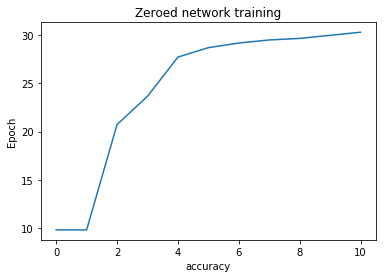

In [18]:
reset_network_zero()
metrics = train(0.5, epoch_per_train=10, step_per_epoch=2000)

matplotlib.pyplot.xlabel('accuracy')
matplotlib.pyplot.ylabel('Epoch')
matplotlib.pyplot.title("Zeroed network training")
matplotlib.pyplot.plot(metrics["epochs"], metrics["accuracy"])
print()

The maximum accuracy obtained should approach 30%, which is not good. Before fixing the element we missed to get a nicely working network we will see the actual results of the network the verify them.

In [19]:
prediction = predict(mnist_data.validation.images[1])
print(prediction)
print(np.argmax(prediction))
print(mnist_data.validation.labels[1])

[  9.62701720e-01   2.82304703e-17   4.00658925e-02   3.93747229e-02
   5.33216643e-02   2.03059866e-01   7.63659451e-02   6.25773869e-02
   4.53792440e-02   6.70348674e-02]
0
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Wether the network is right or not the output should not be to far of the result (the right answer should be in the top 3 of the results).

Because we only select of the highest output the accuracy doesn't necessarely show the progression of the learning, the loss on the other hand should be decreasing consistenly (until the network reach a local minimum).

We will output some testing outputs to check our metrics is representative of the reality

In [20]:
validation_data = mnist_data.validation.next_batch(20)
for i in range(20):
    print(np.argmax(predict(validation_data[0][i])), np.argmax(validation_data[1][i]))

0 6
1 1
8 8
8 4
5 3
0 0
5 4
5 9
5 6
0 4
5 7
5 2
5 7
0 0
5 4
8 4
8 9
5 4
8 7
5 4


### Uniform initialization

So far we miss something important : we initialized naively to 0 all the weights. The initialization problem can be spotted when the training start slowly at the begining before groing fast (or not training at all).

Indeed during the back progagation the delta of the weights are calculated with the activation the the layer before, other reasons make the network not converging to a nice minimum from this all 0 network.

We will try a randomize uniform initialization from -0.5 to 0.5, we want small weights at the begining (center at 0 like the activation wich is sigmoid).

In [21]:
def reset_network_uniform():
    for layer_index in range(1, len(layers)):
        # random numbers between -0.5 and 0.5
        weights[layers[layer_index]] = np.random.random(
            (neuron_outputs[layers[layer_index - 1]].shape[0],
             neuron_outputs[layers[layer_index]].shape[0])) - 0.5
        biases[layers[layer_index]] = np.zeros(neuron_outputs[layers[layer_index]].shape[0])

reset_network_uniform()
plot_weigths = weights["fc1"].flatten()
matplotlib.pyplot.hist(plot_weigths, 100, normed=1)
matplotlib.pyplot.xlabel('X')
matplotlib.pyplot.ylabel('Y')
matplotlib.pyplot.title("Uniform FC1 weight distribution")
print()

Because the network will be so much better from now the learning rate of 0.2 (instead of 0.5) and step per epoch of 800 (instead of 2000) is enough to train. Those numbers are also better to get a nice representation of a training session (not saturation to soon nor too late).

In [22]:
reset_network_uniform()
metrics = train(0.2, epoch_per_train=10, step_per_epoch=800)

matplotlib.pyplot.xlabel('epoch')
matplotlib.pyplot.ylabel('accuracy')
matplotlib.pyplot.title("Uniform network training")
matplotlib.pyplot.plot(metrics["epochs"], metrics["accuracy"])
print()

First metrics => accuracy: 5.2%, loss: 1.392921
End of epoch 0 (800 total inputs) => accuracy: 52.1%, loss: 0.336669
End of epoch 1 (1600 total inputs) => accuracy: 66.9%, loss: 0.254308
End of epoch 2 (2400 total inputs) => accuracy: 75.2%, loss: 0.207650
End of epoch 3 (3200 total inputs) => accuracy: 78.7%, loss: 0.180113
End of epoch 4 (4000 total inputs) => accuracy: 80.8%, loss: 0.162498
End of epoch 5 (4800 total inputs) => accuracy: 82.2%, loss: 0.150746
End of epoch 6 (5600 total inputs) => accuracy: 83.1%, loss: 0.142663
End of epoch 7 (6400 total inputs) => accuracy: 83.5%, loss: 0.137072
End of epoch 8 (7200 total inputs) => accuracy: 83.9%, loss: 0.133184
End of epoch 9 (8000 total inputs) => accuracy: 84.0%, loss: 0.130719



By just training through 4000 inputs with a very high learning rate we already achieved more than 80% accuracy.

Initializing the weight seems to be a nice way to achieve good results so lets improve it once again see how far can the network goes.

### Xavier initialization

Instead of having a uniform distribution a gaussian is a better way to set the weights. The Xavier initialization is using the guassian approach and normalizing the weight with the number of neurons of the layer before so that the "delta" will be normalized as well

In [23]:
def reset_network_xavier():
    for layer_index in range(1, len(layers)):
        last_layer_neuron_count = neuron_outputs[layers[layer_index - 1]].shape[0]
        layer_neuron_count = neuron_outputs[layers[layer_index]].shape[0]
        weights[layers[layer_index]] = np.random.randn(
            last_layer_neuron_count, layer_neuron_count) * np.sqrt(2.0 / last_layer_neuron_count)
        biases[layers[layer_index]] = np.zeros(neuron_outputs[layers[layer_index]].shape[0])

reset_network_xavier()
plot_weigths = weights["fc1"].flatten()
matplotlib.pyplot.hist(plot_weigths, 100, normed=1)
matplotlib.pyplot.xlabel('X')
matplotlib.pyplot.ylabel('Y')
matplotlib.pyplot.title("Xavier FC1 weight distribution")
print()

In [24]:
reset_network_xavier()
metrics = train(0.2, epoch_per_train=10, step_per_epoch=800)

matplotlib.pyplot.xlabel('epoch')
matplotlib.pyplot.ylabel('accuracy')
matplotlib.pyplot.title("Xavier initialized network training")
matplotlib.pyplot.plot(metrics["epochs"], metrics["accuracy"])
print()

First metrics => accuracy: 11.3%, loss: 1.853879
End of epoch 0 (800 total inputs) => accuracy: 58.5%, loss: 0.296729
End of epoch 1 (1600 total inputs) => accuracy: 78.1%, loss: 0.212095
End of epoch 2 (2400 total inputs) => accuracy: 82.4%, loss: 0.168598
End of epoch 3 (3200 total inputs) => accuracy: 83.8%, loss: 0.148284
End of epoch 4 (4000 total inputs) => accuracy: 84.3%, loss: 0.137502
End of epoch 5 (4800 total inputs) => accuracy: 84.7%, loss: 0.131299
End of epoch 6 (5600 total inputs) => accuracy: 84.9%, loss: 0.127398
End of epoch 7 (6400 total inputs) => accuracy: 85.0%, loss: 0.124817
End of epoch 8 (7200 total inputs) => accuracy: 85.0%, loss: 0.122841
End of epoch 9 (8000 total inputs) => accuracy: 85.2%, loss: 0.121091



This time the improvement wasn't that big, we can get better accuracy by training with a lower training rate and giving way more data so we will not overshoot the local minima and get a bigger dataset (important to generalize and not overfit).

First metrics => accuracy: 12.2%, loss: 1.519370
End of epoch 0 (5000 total inputs) => accuracy: 61.2%, loss: 0.324976
End of epoch 1 (10000 total inputs) => accuracy: 75.8%, loss: 0.240633
End of epoch 2 (15000 total inputs) => accuracy: 83.2%, loss: 0.188109
End of epoch 3 (20000 total inputs) => accuracy: 85.8%, loss: 0.156932
End of epoch 4 (25000 total inputs) => accuracy: 87.3%, loss: 0.138092
End of epoch 5 (30000 total inputs) => accuracy: 88.0%, loss: 0.125798
End of epoch 6 (35000 total inputs) => accuracy: 88.5%, loss: 0.117251
End of epoch 7 (40000 total inputs) => accuracy: 88.9%, loss: 0.110942
End of epoch 8 (45000 total inputs) => accuracy: 89.2%, loss: 0.106049
End of epoch 9 (50000 total inputs) => accuracy: 89.4%, loss: 0.102115



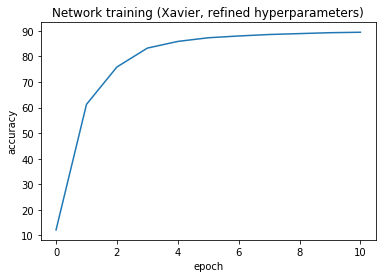

In [25]:
reset_network_xavier()
metrics = train(0.02, epoch_per_train=10, step_per_epoch=5000)

# ploting the metrics
matplotlib.pyplot.xlabel('epoch')
matplotlib.pyplot.ylabel('accuracy')
matplotlib.pyplot.title("Network training (Xavier, refined hyperparameters)")
matplotlib.pyplot.plot(metrics["epochs"], metrics["accuracy"])
print()

### ReLU activation

We can also use an other activation function like ReLU. ReLu is often better in usual situation, it is also harder to train. For this very small and simple 16/10 neuron network andding the ReLU complexity will not improve our network and make it way longer to learn.

We will still implement it by redefining the activation function, first we will define Relu.

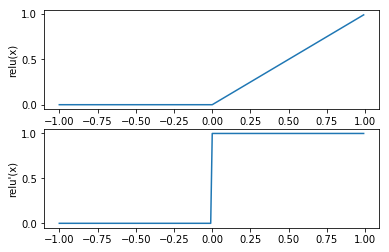

In [26]:
# ReLU
def relu(p_input):
    return p_input * (p_input > 0)  # fastest ReLU implementation with numpy

def relu_prime(p_input):
    return p_input > 0

plot_x = np.arange(-1, 1, 0.01)
matplotlib.pyplot.figure(1)
matplotlib.pyplot.subplot(211)
matplotlib.pyplot.ylabel("relu(x)")
matplotlib.pyplot.plot(plot_x, relu(plot_x))
matplotlib.pyplot.subplot(212)
matplotlib.pyplot.ylabel("relu'(x)")
plot_x = np.arange(-1, 1, 0.01)
matplotlib.pyplot.plot(plot_x, relu_prime(plot_x))
print()

Because our implementation relies on calling `activation` and `activation_prime` we will just having to redifine those.

In [27]:
# Redefining activation function to use ReLU
def activation(p_input):
    return relu(p_input)

def activation_prime(p_input):
    return relu_prime(p_input)

The ReLU activation is more sensible to weight changes (this can be understand seing the shape of the function). The learning rate has to be very low compared to sigmoid (sharp minima).

First metrics => accuracy: 9.0%, loss: 0.537820
End of epoch 0 (6000 total inputs) => accuracy: 28.5%, loss: 0.436075
End of epoch 1 (12000 total inputs) => accuracy: 34.5%, loss: 0.406158
End of epoch 2 (18000 total inputs) => accuracy: 41.4%, loss: 0.377896
End of epoch 3 (24000 total inputs) => accuracy: 49.2%, loss: 0.347695
End of epoch 4 (30000 total inputs) => accuracy: 56.3%, loss: 0.315846
End of epoch 5 (36000 total inputs) => accuracy: 60.4%, loss: 0.289263
End of epoch 6 (42000 total inputs) => accuracy: 63.0%, loss: 0.269813
End of epoch 7 (48000 total inputs) => accuracy: 66.3%, loss: 0.253405
End of epoch 8 (54000 total inputs) => accuracy: 69.7%, loss: 0.238414
End of epoch 9 (60000 total inputs) => accuracy: 72.5%, loss: 0.225111
End of epoch 10 (66000 total inputs) => accuracy: 75.1%, loss: 0.212816
End of epoch 11 (72000 total inputs) => accuracy: 77.3%, loss: 0.200789
End of epoch 12 (78000 total inputs) => accuracy: 79.4%, loss: 0.190408
End of epoch 13 (84000 tota

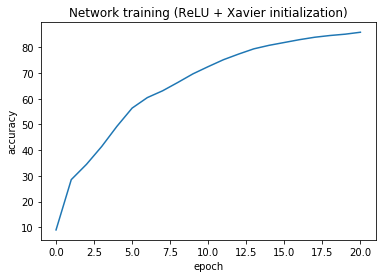

In [28]:
reset_network_xavier()
metrics = train(0.0002, epoch_per_train=20, step_per_epoch=6000)

matplotlib.pyplot.xlabel('epoch')
matplotlib.pyplot.ylabel('accuracy')
matplotlib.pyplot.title("Network training (ReLU + Xavier initialization)")
matplotlib.pyplot.plot(metrics["epochs"], metrics["accuracy"])
print()

## Mini batch training

The implentation we did so far was updating the network to optimize itself regarding only one input at a time : this is also called **online training**.

When we try to minimize the cost for one input we might also increase it for an other input. This is especially likely to be happening for inputs of other classes. To avoid this sub-optimal training we can get results of the back propagation for the set of input (a batch), then compile/aggregate them into one update (usually by averaging). This way every step of the training will converge better to the minima we're aiming at : this is the **mini-batch training**

The most optimal way would be to use the whole dataset every step, but this would be incredibly slow in practise.

Especially for complex network mini batch greatlys improve the training.

We will first define the new train function :

In [29]:
def mini_batch_train(learning_rate, epoch_per_train=1, step_per_epoch=1, mini_batch_size=4):
    metrics = {"epochs": [], "accuracy": [], "loss": []}
    # Get metrics and printing them (before training)
    metric = test_metrics()
    metrics["epochs"].append(0)
    metrics["accuracy"].append(metric[0])
    metrics["loss"].append(metric[1])
    print("First metrics => accuracy: %.01f%%, loss: %f" % (
        metrics["accuracy"][-1], metrics["loss"][-1]))

    for epoch in range(epoch_per_train):
        for step in range(step_per_epoch):
            batch = mnist_data.train.next_batch(mini_batch_size)
            # initializing the update values
            weight_updates = {}
            bias_updates = {}
            for layer in layers[1:]:
                weight_updates[layer] = np.zeros(weights[layer].shape)
                bias_updates[layer] = np.zeros(biases[layer].shape[0])

            for batch_iterator in range(mini_batch_size):
                batch_bias_updates, batch_weight_updates = backprop(batch[0][batch_iterator], batch[1][batch_iterator])
                # adding the updates
                for layer in layers[1:]:
                    weight_updates[layer] += batch_weight_updates[layer]
                    bias_updates[layer] += batch_bias_updates[layer]

            # updating
            for layer in layers[1:]:
                weights[layer] -= (learning_rate / mini_batch_size) * weight_updates[layer]
                biases[layer] -= (learning_rate / mini_batch_size) * bias_updates[layer]
        # Get metrics and printing them (in training)
        metric = test_metrics()
        metrics["epochs"].append(epoch + 1)
        metrics["accuracy"].append(metric[0])
        metrics["loss"].append(metric[1])
        print("End of epoch %d (%d total inputs) => accuracy: %.01f%%, loss: %f" % (
            epoch, (epoch + 1) * step_per_epoch * mini_batch_size,
            metrics["accuracy"][-1], metrics["loss"][-1]))
    return metrics

The most complex network we have so far is the ReLU version, we will use mini batch training on it :

First metrics => accuracy: 7.5%, loss: 0.703525
End of epoch 0 (16000 total inputs) => accuracy: 38.0%, loss: 0.377431
End of epoch 1 (32000 total inputs) => accuracy: 53.0%, loss: 0.312796
End of epoch 2 (48000 total inputs) => accuracy: 64.2%, loss: 0.259943
End of epoch 3 (64000 total inputs) => accuracy: 68.0%, loss: 0.235500
End of epoch 4 (80000 total inputs) => accuracy: 69.5%, loss: 0.222822
End of epoch 5 (96000 total inputs) => accuracy: 70.4%, loss: 0.214218
End of epoch 6 (112000 total inputs) => accuracy: 70.9%, loss: 0.208559
End of epoch 7 (128000 total inputs) => accuracy: 71.5%, loss: 0.203823
End of epoch 8 (144000 total inputs) => accuracy: 71.8%, loss: 0.200459
End of epoch 9 (160000 total inputs) => accuracy: 72.1%, loss: 0.197041



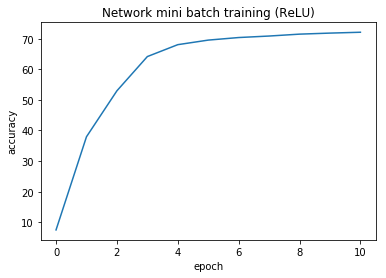

In [30]:
reset_network_xavier()
metrics = mini_batch_train(0.005, epoch_per_train=10, step_per_epoch=500, mini_batch_size=32)

matplotlib.pyplot.xlabel('epoch')
matplotlib.pyplot.ylabel('accuracy')
matplotlib.pyplot.title("Network mini batch training (ReLU)")
matplotlib.pyplot.plot(metrics["epochs"], metrics["accuracy"])
print()

The mini batching is usually getting better result than the online training (the training are still very quick to get stable results), because every update is more precisely oriented toward the minima (in the multiple dimmensions). We can have a greater learning rate (counter-balancing the fact that we need to parse more data per step).

## Conclusion

This notebook will hopefully make you more confortable about the internal processes of a deep neural network. The **back propagation** is one of the key concept that enable the network optimisation towards **minimizing the distance between predictions and true results**. The **weight initialization** is really important and can lead to very different results, also different activation functions can have their pros and cons.